<h1 style="font-size: 40px; margin-bottom: 0px;">2.2 Statistical Analysis in Python (II)</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 700px;"></hr>

We'll continue practicing some more statistical analysis using the data that we've collected from MCB201A. Like with notebook 2-1, this notebook will lean more towards independent exercises, and in the first exercise, you'll run a regression analysis using your group's BCA assay absorbance data and use the resulting standard curve to quantify the protein concentrations of your samples. You'll also run a linear regression on our class xenograft data to determine if there is a strong correlation between tumor volume and tumor weight and if that changes upon TAZ KO. Then you'll learn how to take what you've done so far and apply it to setting up a Python script to analyze some hypothetical results to learn one approach towards setting up a streamlined analysis workflow.

<strong>Learning objectives:</strong>
<ul>
    <li>Practice linear regression in Python</li>
    <li>Additional plotting practice</li>
    <li>More operating system functionalities</li>
    <li>Setting up a basic module</li>
    <li>Creating a Python script for analysis</li>
    <li>Execute a Python script</li>
</ul>

<h2>Import Packages</h2>

In [1]:
#Import our packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os

<h1 style="font-size: 40px; margin-bottom: 0px;">Exercise #1 - Linear regression for calibration</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 850px;"></hr>

For this first exercise, you'll run a regression analysis on your group's BCA data and then use that resulting information to calculate the concentrations of your unknown protein samples. This will also touch on some of the steps from your homework assignment as well and can hopefully help if you haven't started on it yet.

First load in your BCA data - you can use the file that you uploaded for your Week 1 homework assignment and leave in the standards and unknowns.

In [5]:
bca = pd.read_csv('/home/jovyan/MCB201B_F2025/Week_1/week_1_homework/G5_BCA.csv',
                  skiprows=23,
                  nrows=2,
                  index_col='Unnamed: 1'
                 )

In [6]:
bca.style

,Unnamed: 0,1,2,3,4,5,6,7,8,9,10,11,12,Unnamed: 14
A,nan,1.060000,0.880000,0.682000,0.538000,0.419000,0.273000,0.209000,0.138000,0.118000,0.263000,0.317000,nan,BCA read:562
B,nan,1.068000,0.870000,0.660000,0.509000,0.406000,0.267000,0.196000,0.128000,0.117000,0.245000,0.290000,nan,BCA read:562


Let's do a quick sanity check to see how it imported.

If you need, make small adjustments to your DataFrame and update the column labels.

In [8]:
bca.drop(columns=['Unnamed: 0', '12', 'Unnamed: 14'], inplace=True)

In [9]:
bca.style

,1,2,3,4,5,6,7,8,9,10,11
A,1.060000,0.880000,0.682000,0.538000,0.419000,0.273000,0.209000,0.138000,0.118000,0.263000,0.317000
B,1.068000,0.870000,0.660000,0.509000,0.406000,0.267000,0.196000,0.128000,0.117000,0.245000,0.290000


In [11]:
new_names = [2.0, 1.5, 1.0, 0.75, 0.5, 0.25, 0.125, 0.025, 0, 'ko', 'ctrl']

for old, new in zip(bca.columns, new_names):
    bca.rename(columns={old:new}, inplace=True)

Let's take a look to see how it updated.

In [12]:
bca.style

,2.000000,1.500000,1.000000,0.750000,0.500000,0.250000,0.125000,0.025000,0,ko,ctrl
A,1.060000,0.880000,0.682000,0.538000,0.419000,0.273000,0.209000,0.138000,0.118000,0.263000,0.317000
B,1.068000,0.870000,0.660000,0.509000,0.406000,0.267000,0.196000,0.128000,0.117000,0.245000,0.290000


Now, like with our homework assignment, let's split our unknowns from our standards. We can save each one to it's own variable.

In [14]:
bca_standard = bca.loc[:, 2:0]

In [15]:
bca_standard.style

,2.000000,1.500000,1.000000,0.750000,0.500000,0.250000,0.125000,0.025000,0
A,1.060000,0.880000,0.682000,0.538000,0.419000,0.273000,0.209000,0.138000,0.118000
B,1.068000,0.870000,0.660000,0.509000,0.406000,0.267000,0.196000,0.128000,0.117000


In [16]:
bca_unknowns = bca.loc[:, ['ctrl', 'ko']]
bca_unknowns.style

,ctrl,ko
A,0.317000,0.263000
B,0.290000,0.245000


Let's see how the two resulting DataFrames look now.

<h2>Correct for background absorbance</h2>

Now let's correct for background absorbance using the mean of the background replicates.

In [19]:
bca_std_corr = bca_standard - bca_standard.loc[:,0].mean()

In [20]:
bca_std_corr

,2.0,1.5,1.0,0.75,0.5,0.25,0.125,0.025,0
A,0.9425,0.7625,0.5645,0.4205,0.3015,0.1555,0.0915,0.0205,0.0005
B,0.9505,0.7525,0.5425,0.3915,0.2885,0.1495,0.0785,0.0105,-0.0005


In [21]:
bca_unk_corr = bca_unknowns - bca_standard.loc[:,0].mean()

In [22]:
bca_unk_corr.style

,ctrl,ko
A,0.199500,0.145500
B,0.172500,0.127500


<h2>Run a linear regression analysis</h2>

With your mean corrected absorbances, use <code>stats.linregress()</code> to run a linear regression analysis using your protein standards. <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html" rel="noopener noreferrer"><u>Documentation for <code>stats.linregress()</code> can be found here.</u></a>

In [23]:
bca_std_corr.mean()

2.0      9.465000e-01
1.5      7.575000e-01
1.0      5.535000e-01
0.75     4.060000e-01
0.5      2.950000e-01
0.25     1.525000e-01
0.125    8.500000e-02
0.025    1.550000e-02
0        6.938894e-18
dtype: float64

In [24]:
bca_std_corr.loc['mean',:] = bca_std_corr.mean()

In [25]:
bca_std_corr.style

,2.000000,1.500000,1.000000,0.750000,0.500000,0.250000,0.125000,0.025000,0
A,0.942500,0.762500,0.564500,0.420500,0.301500,0.155500,0.091500,0.020500,0.000500
B,0.950500,0.752500,0.542500,0.391500,0.288500,0.149500,0.078500,0.010500,-0.000500
mean,0.946500,0.757500,0.553500,0.406000,0.295000,0.152500,0.085000,0.015500,0.000000


In [26]:
bca_unk_corr.loc['mean',:] = bca_unk_corr.mean()

In [27]:
bca_unk_corr.style

,ctrl,ko
A,0.199500,0.145500
B,0.172500,0.127500
mean,0.186000,0.136500


In [30]:
list(bca_std_corr.columns)

[2.0, 1.5, 1.0, 0.75, 0.5, 0.25, 0.125, 0.025, 0]

In [31]:
bca_std_reg = stats.linregress(list(bca_std_corr.columns),
                               bca_std_corr.loc['mean',:]
                              )

<h2>Calculate the concentration of your unknowns</h2>

If you dig into the documentation for <code>stats.linregress()</code>, you'll find that it returns an object that contains various attributes. The ones that we're interested in for calculating the concentration of our unknown samples are the <code>slope</code> and the <code>intercept</code>. Recall from MCB201A, that we can then use these values to calculate our protein concentrations because we have the absorbance measurements of our unknown samples.


We can use the equation for a line:

```
y = mx + b
```

Where <code>m</code> is the <code>slope</code>, and <code>b</code> is the <code>intercept</code>, and <code>y</code> is our unknown's mean corrected absorbance value.

See if you can calculate the protein concentrations of your unknown and assign the resulting values to a new row in your unknown sample's DataFrame.

In [33]:
m = bca_std_reg.slope
b = bca_std_reg.intercept

In [34]:
y = (bca_unk_corr.loc['mean',:] - b)/m

In [35]:
y

ctrl    0.327197
ko      0.224005
Name: mean, dtype: float64

<h2>Plot protein standards, linear regression model, and unknowns</h2>

For your homework assignment, you plotted a scatterplot of your mean corrected absorbance values for your protein standards. Here, you'll make use of the <code>sns.regplot()</code> function to not only plot the protein standards but also the linear regression model derived from your standards. <a href="https://seaborn.pydata.org/generated/seaborn.regplot.html" rel="noopener noreferrer"><u>Documentation for <code>sns.regplot()</code> can be found here.</u></a>

Then plot your unknown protein samples on top of your linear regression plot, and distinguish your unknowns using a different color.

<Axes: xlabel='mean', ylabel='mean'>

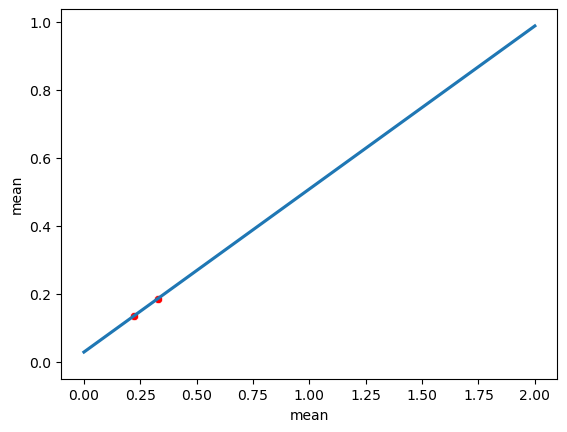

In [46]:
sns.regplot(x=list(bca_std_corr.columns),
            y=bca_std_corr.loc['mean',:],
            ci=None,
            scatter_kws={'visible':False}
           )

sns.scatterplot(x=y,
                y=bca_unk_corr.loc['mean',:],
                color='r',
                s=36
               )

<h1 style="font-size: 40px; margin-bottom: 0px;">Exercise #2 - Linear regression to evaluate correlation</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 975px;"></hr>

Let's now load in our class xenograft data again, and this time, we can run a linear regression analysis to determine if there is a correlation between tumor weight and tumor volume. We can run this analysis first for our control samples and then our TAZ KO samples and determine if there TAZ KO could change the strength of this correlation.

First import the class xenograft data. We can use the same file that we used in 2-1.

As usual, let's do a quick sanity check.

We can just quickly re-update our DataFrame to convert grams to milligrams for our tumor weights.

For those of you who want a slight challenge, see if you can do this in a single line to convert all the weight values from grams to milligrams. This will make use of <code>pd.Series.str.contains()</code> to generate a boolean output, which you can then use with <code>.loc[]</code> to pull just the rows related to weight. You can then make use of multiplicative assignment to update these values in the original DataFrame.

<a href="https://pandas.pydata.org/docs/reference/api/pandas.Series.str.contains.html" rel="noopener noreferrer"><u>Documentation for <code>pd.Series.str.contains()</code> can be found here.</u></a>

<h2>Determine if there is a correlation between control tumor weights and volumes</h2>

Let's now make use of <code>stats.linregress()</code> to evaluate the strength of the relationship between tumor weights and volumes for our control samples first. Recall that <code>stats.linregress()</code> generates an object containing multiple attributes. We pulled out the <code>slope</code> and the <code>intercept</code> in exercise #1, and for this exercise, we'll pull out the <code>rvalue</code>, which is the Pearson correlation coefficient which we can then use to calculate the R&sup2; value.

Let's take a look at the regression model too using <code>sns.regplot()</code>.

<h2>Determine if there is a correlation between TAZ KO tumor weights and volumes</h2>

Let's do the same for our TAZ KO tumors.

At a preliminary glance, what does our data tell us about whether or not TAZ KO influences this correlation?

<h1 style="font-size: 40px; margin-bottom: 0px;">Additional operating system functionalities</h1>
<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 800px;"></hr>

<h2>Make directories</h2>

Recall from earlier notebooks, where we made use of the <code>os</code> module to change directories, get our current working directory, and load in multiple files into our notebook for analysis. We can also perform additional operating system functions including making new directories. This can be helpful when you want to keep your outputs organized and have set directories created to hold different outputs, so you don't need to create them each time you run an analysis.

Here, we can use the <code>os.mkdir()</code> function to make a new directory. <a href="https://docs.python.org/3/library/os.html#os.mkdir" rel="noopener noreferrer"><u>Documentation for <code>os.mkdir()</code> can be found here.</u></a>

This function will make a new directory according to the file path specified as long as the parent directories exist. For our purposes, we can test out making a new directory in our current working directory, so all we need to specify is the name of the directory.

Let's first see where our notebook's current working directory is.

Now let's make a new directory called <code>mcb201b_modules</code>. We will use this directory in a subsequent section of this notebook.

You can specify the name of the directory as a string when using the <code>os.mkdir()</code> function.

Now try re-running that code cell again and see what happens. You can see that if the directory already exists, you'll get a <code style="background-color: #FFDDDD; color: #FF0000;">FileExistsError</code>. To get around this, we can make use of the <code>try</code> keyword and provide it with a way to handle the error by using the <code>except</code> and <code>pass</code> keyword.

<h2>Setting up a base name</h2>

While not necessarily a specific operating system function, it can be helpful when you want to analyze multiple files to be able to set up a base name that will be shared between all the outputs that are generated when you analyze a data file. For today's class, we'll be analyzing a dataset that was generated from hypothetical testing of different small molecules. Since it's a number of different data files, it can be helpful to distinguish the analysis outputs from one another.

What we can do is to be consistent in how we format our file names, so we can readily use it to create a base name for that respective file's outputs.

Let's use what we know so far to pull in file names from a small molecule screen under the file path <code>./data/small_mol_mtt_data</code>.

Let's pull in just our .csv file names.

Recall that the file names are strings, so we can take advantage of The way strings are handled in Python to allow us to generate a base name that adapts to each file. Each letter of a string functions like an element of a list, so we can pull just the information we want from a file name.

Let's use just the first file name as an example.

What can we do if we just wanted to pull out the small molecule identifier from our file name?

Let's see if that will work for all our file names.

Now all we need to do if we want to use this base name for naming our output files is to combine it with an appropriate suffix.

<h2>Writing output summary logs</h2>

Something that you may want to do while analyzing multiple data files is to also have Python output a log or summary of the analysis results, so you can refer back to that summary log to understand what was going on during the analysis and what the outputs were. To have Python write to a file, you can make use of the <code>with</code> keyword and the built-in <code>open()</code> function to open a file up (or create a new one if it doesn't exist). <a href="https://docs.python.org/3/library/functions.html#open" rel="noopener noreferrer"><u>Documentation for <code>open()</code> can be found here.</u></a>

Digging into the documentation for <code>open()</code>, you can see that there are different modes under which the <code>open()</code> function can operate. Two common modes are <code>'w'</code>, which is to write from the beginning of the file (and overwriting any previous information), and <code>'a'</code> which appends onto the file's existing information.

The <code>with</code> keyword serves to automatically close out the file that you open/create with the <code>open()</code> function, so you don't have to separately remember to close the file. We will then use the <code>as</code> keyword to set a variable name to our open file.

With the file open, you can then make use of your file's variable name and the <code>write()</code> method to write into that file.

We can give that a try here to output a plain text .txt file in this week's <code>output</code> directory.

Let's then see what happens if we use the append mode <code>'a'</code> instead of the write mode <code>'w'</code>.

What happens if you re-run the cell multiple times? Compare that to when we were in the write mode.

Now what could we do if we wanted to have line breaks?

<h1 style="font-size: 40px; margin-bottom: 0px;">Creating a basic module</h1>
<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 800px;"></hr>

Recall from our data visualization notebooks that we set up a nice function for putting together a publication quality figure that includes descriptive statistics overlaid on it as well as annotations to indicate the results of our statistical analysis. Since it would be inconvenient to have to recopy that block of code into each file that we want to run it, we can set up our own basic module that defines this function. Recall that our Python packages like <code>numpy</code> and <code>pandas</code> contain within them a bunch of functions that have been defined and can be imported into our notebooks or Python files to allow those blocks of code to be readily used. 

We can similarly set up our own module for our annotated swarmplot. I've copied below our swarmplot code, and all we'll need to do is to make some minor adjustments to give it additional flexibility and allow it to use other packages. Then we can set up our module as its own .py Python file.

In [ ]:
def swarmplot_annotation(dataset, col_list, conclusion, y_axislabel, file_name):
    
    fig, ax = plt.subplots()
    dot_colors = ['#777777', '#E64B35']
    
    sns.swarmplot(data=dataset[col_list],
                  s=8,
                  palette=dot_colors,
                  zorder=0
                 )
    
    sns.barplot(data=dataset[col_list],
                estimator=np.mean,
                alpha=0,
                errorbar='se',
                capsize=0.3,
                err_kws={'linewidth': 1,
                         'color': 'k'}
               )
    
    sns.boxplot(data=dataset[col_list],
                showmeans=True,
                meanline=True,
                width=0.5,
                meanprops={'linewidth': 1,
                           'color': 'k',
                           'linestyle': '-'
                          },
                medianprops={'visible': False},
                whiskerprops={'visible': False},
                showfliers=False,
                showbox=False,
                showcaps=False
               )
    
    #####################################
    x1, x2 = 0, 1
    y_max = np.max(dataset[col_list].max())
    adjustment = y_max*1.1
    h = y_max*0.05
    
    plt.plot([x1, x1, x2, x2], [adjustment, adjustment + h, adjustment + h, adjustment], color='k')
    #####################################
    
    #####################################
    if conclusion.pvalue < 0.0001:
        pvalue_star = '***'
    elif conclusion.pvalue < 0.001:
        pvalue_star = '**'
    elif conclusion.pvalue < 0.01:
        pvalue_star = '*'
    else:
        pvalue_star = 'ns'
    
    plt.text((x1+x2)/2 , adjustment+(h*1.25), pvalue_star, ha='center', va='bottom', color='k', size=12)
    #####################################
    
    ax.set_ylabel(y_axislabel,
                  size=14
                 )
    
    ax.set_xticks([0,1],
                  ['Control', '$TAZ$ KO'],
                  rotation=35,
                  ha='right',
                  size=12
                 )
    plt.yticks(size=12)
    
    fig.set_size_inches(3, 4)
    fig.set_dpi(300)
    
    sns.despine()
    plt.show()
    
    fig.savefig(f'./outputs/{file_name}.pdf', bbox_inches='tight')

The function as it is now isn't too useful for us to import, so we'll need to set up it's own .py Python file.

To set up for this, navigate into <code>mcb201b_modules</code> using your left-hand File Browser. Then open up a new Launcher. Recall that Python packages are indicated by a <code>&lowbar;&lowbar;init&lowbar;&lowbar;.py</code> file. Within <code>mcb201b_modules</code> create a new Python file using the Launcher. By default, the newly created .py file will be <code>Untitled.py</code>. Go ahead and save the empty .py file, and you'll be prompted to rename it. Rename the file to <code>&lowbar;&lowbar;init&lowbar;&lowbar;.py</code> (the "init" is flanked by two underscores). 

Now the Python interpreter will know that our <code>mcb201b_modules</code> directory is a package that can be imported. Now create another new Python file. This one will be our basic module containing our <code>swarmplot_annotation()</code> function.

In this new file, copy over our updated definition including the <code>import</code> operations to make sure that dependencies are included. Save the .py file as <code>mcb201b_swarmplot_annotated.py</code>.

<h2>Import our basic module</h2>

Let's see if we're able to import our module. First we'll want to make sure that we're back into our <code>Week_2</code> directory.

Then we can import our module with the <code>import</code> function, and we can import it as <code>mcb201b</code>.

We can do a quick check by calling up <code>mcb201b</code> object to see if it is recognized as a module with the correct file path.

We can then check to see if our function is defined.

<h1 style="font-size: 40px; margin-bottom: 0px;">Setting up a Python script</h1>
<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 800px;"></hr>

With our module looking like it's ready to go, we can start putting together a basic Python script. We'll make use of everything we've learned so far from MCB201A's Exp 16 to today to set up this script and run an analysis of a dataset from a small molecule test.

To get ourselves started, let's use the File Browser and navigate back to our <code>Week_2</code> directory. Then let's use the Launcher to start up a new .py file. We can name the Python file <code>small_mol_mtt_script.py</code>, and we will shift over to working in that Python file as we set up our script. While working in our <code>small_mol_mtt_script.py</code> file, we will open up a console editor allowing us to test our code much in the same way you can do in RStudio for those of you who have more familiarity with R and RStudio.

We might also sometimes jump back into our notebooks to find some code that we can use in our script.

<h1 style="font-size: 40px; margin-bottom: 0px;">Running your Python script</h1>
<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 800px;"></hr>

With our script set up, we can simply go into Terminal, confirm that we're in our <code>Week_2</code> directory, and run our Python script through Terminal by invoking the Python interpreter and executing our <code>small_mol_mtt_script.py</code> file.

<pre style="width: 350px; margin-top: 15px; margin-bottom: 15px; color: #000000; background-color: #EEEEEE; border: 1px solid; border-color: #AAAAAA; padding: 10px; border-radius: 15px; font-size: 12px;">python small_mol_mtt_script.py</pre>

And if all goes well, you should be able to run the analysis on all the small molecule data files.